# MLP trained on the Fashion-MNIST dataset using PyTorch

In [1]:
from torch.nn import Sequential, Flatten, Linear, CrossEntropyLoss, ReLU
from torch.optim import SGD
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch import arange, argmax
import torch
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from math import floor
from matplotlib import pyplot as plt
import wandb
from pprint import pprint

## Login to Wandb

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load best hyperparameters from the Tensorflow run

In [3]:
api = wandb.Api()
sweep = api.sweep("nsiete23/tf_mlp/sweeps/ez31t9fh")

best_config = sweep.best_run().config
pprint(best_config)

wandb.init(config=best_config, project='torch_mlp', name='best-mlp-torch')
config = wandb.config

wandb: Sorting runs by +summary_metrics.val_loss
wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


{'batch_size': 128,
 'dense_1': 359,
 'dense_2': 179,
 'dense_3': 137,
 'dense_4': 64,
 'epochs': 20,
 'learning_rate': 0.058011500502312935,
 'momentum': 0.04032910145774373}


## Load dataset

In [4]:
data = FashionMNIST(root='../data', download=True, transform=ToTensor())
test = FashionMNIST(root='../data', download=True, train=False, transform=ToTensor())

data_length = len(data)
validation_split = 0.2
validation_size = floor(validation_split * data_length)
batch_size = config.batch_size

validation = Subset(data, arange(validation_size))
train = Subset(data, arange(validation_size, data_length))

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

print(len(train))
print(len(validation))
print(len(test))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

48000
12000
10000


## Define fit function

In [5]:
def fit(model, train_loader, val_loader, optimizer, loss_fn, epochs, batch_size):
    history = {
        'val_loss': [],
        'val_accuracy': [],
        'loss': [],
        'accuracy': []
    }
    for epoch in range(epochs):
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0
        train_loss = 0
        val_loss = 0
        
        for x_train, y_train in train_loader:
            optimizer.zero_grad()
            y_pred_dist = model(x_train)
            y_pred = argmax(y_pred_dist, axis=1)
            loss = loss_fn(y_pred_dist, y_train)
            
            train_loss += loss.item()
            train_total += len(y_train)
            train_correct += (y_pred == y_train).sum().item()
            loss.backward()
            optimizer.step()
            
        for x_val, y_val in val_loader:
            with torch.no_grad():
                y_pred_dist = model(x_val)
                y_pred = argmax(y_pred_dist, axis=1)
                loss = loss_fn(y_pred_dist, y_val)
                val_loss += loss.item()
                val_total += len(y_val)
                val_correct += (y_pred == y_val).sum().item()
                
        val_loss /= len(val_loader.dataset)/batch_size
        train_loss /= len(train_loader.dataset)/batch_size
        
        val_acc = val_correct/val_total
        train_acc = train_correct/train_total
        
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        wandb.log({
            'loss': train_loss,
            'val_loss': val_loss,
            'accuracy': train_acc,
            'val_accuracy': val_acc,
        })
        
        print(f'Epoch {epoch + 1}/{epochs}: loss {train_loss}, val_loss {val_loss}, ' +
             f'accuracy {train_acc}, val_accuracy {val_acc}')
        
    return history

## Create model

In [6]:
mlp = Sequential(
    Flatten(),
    Linear(28 * 28, config.dense_1),
    ReLU(),
    Linear(config.dense_1, config.dense_2),
    ReLU(),
    Linear(config.dense_2, config.dense_3),
    ReLU(),
    Linear(config.dense_3, config.dense_4),
    ReLU(),
    Linear(config.dense_4, 10)
)

loss = CrossEntropyLoss()
optimizer = SGD(mlp.parameters(), lr=config.learning_rate, momentum=config.momentum)

## Train model and finish Wandb run

In [7]:
history = fit(mlp, train_loader, val_loader, optimizer, loss, config.epochs, config.batch_size)
wandb.finish()

Epoch 1/20: loss 1.6973340350786845, val_loss 0.9695234444936116, accuracy 0.3875208333333333, val_accuracy 0.637
Epoch 2/20: loss 0.7358360049724579, val_loss 0.6063468475341797, accuracy 0.7284375, val_accuracy 0.7820833333333334
Epoch 3/20: loss 0.5602283800443013, val_loss 0.6048916285832723, accuracy 0.7962291666666667, val_accuracy 0.7841666666666667
Epoch 4/20: loss 0.49195922311147056, val_loss 0.4465840578079224, accuracy 0.8240208333333333, val_accuracy 0.8423333333333334
Epoch 5/20: loss 0.44433990494410197, val_loss 0.4811959676742554, accuracy 0.8390416666666667, val_accuracy 0.8263333333333334
Epoch 6/20: loss 0.41211879189809164, val_loss 0.39669686603546145, accuracy 0.8494375, val_accuracy 0.8585833333333334
Epoch 7/20: loss 0.3896483118136724, val_loss 0.39172846857706706, accuracy 0.8582291666666667, val_accuracy 0.85425
Epoch 8/20: loss 0.3707718201478322, val_loss 0.3694567068417867, accuracy 0.8645833333333334, val_accuracy 0.8688333333333333
Epoch 9/20: loss 0.35

accuracy,▁▆▇▇▇▇▇▇████████████
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▇▆▇▇▇▇███▇██▇████
val_loss,█▄▄▂▃▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁
accuracy,0.90446
loss,0.25567
val_accuracy,0.891
val_loss,0.31243


## Plot training and validation accuracy and loss

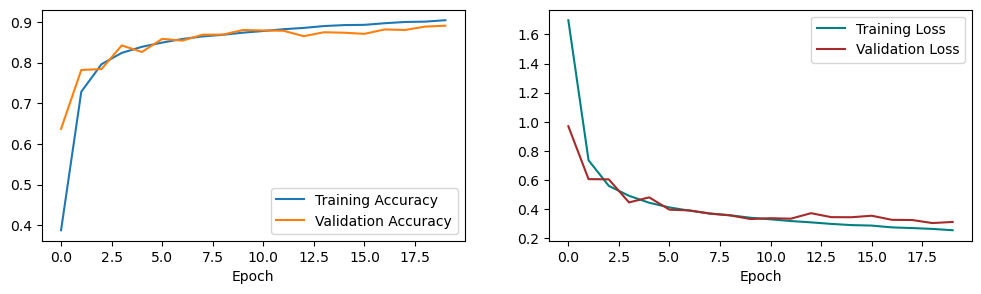

In [8]:
plt.subplots(figsize=(12,3))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss', color='teal')
plt.plot(history['val_loss'], label='Validation Loss', color='brown')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Define class names

In [9]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

## Run classification evaluation

In [10]:
y_test_all = []
y_pred_all = []
total = 0
correct = 0

with torch.no_grad():
    for x_test, y_test in test_loader:
        outputs = mlp(x_test)
        predicted = argmax(outputs, axis = 1)
        y_pred_all.extend(predicted.numpy())
        y_test_all.extend(y_test.numpy())
        total += len(y_test)
        correct += (predicted == y_test).sum().item()

report = classification_report(y_test_all, y_pred_all, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

 T-shirt/top     0.8016    0.8850    0.8413      1000
     Trouser     0.9877    0.9600    0.9736      1000
    Pullover     0.7974    0.7910    0.7942      1000
       Dress     0.8679    0.9000    0.8837      1000
        Coat     0.7945    0.8160    0.8051      1000
      Sandal     0.9563    0.9630    0.9596      1000
       Shirt     0.7314    0.6290    0.6763      1000
     Sneaker     0.9689    0.9030    0.9348      1000
         Bag     0.9730    0.9730    0.9730      1000
  Ankle boot     0.9177    0.9810    0.9483      1000

    accuracy                         0.8801     10000
   macro avg     0.8796    0.8801    0.8790     10000
weighted avg     0.8796    0.8801    0.8790     10000



## Visualize confusion matrix

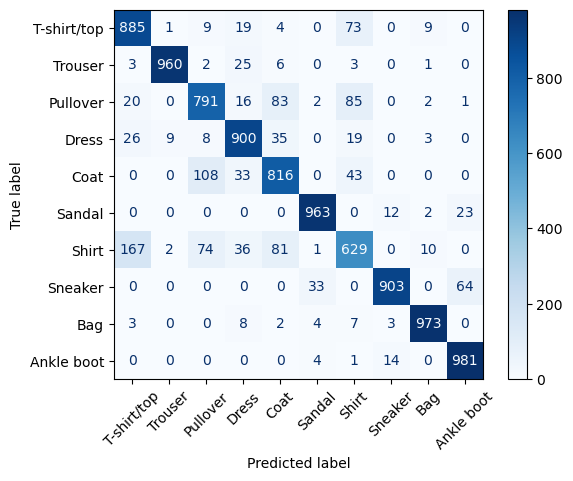

In [11]:
matrix = confusion_matrix(y_test_all, y_pred_all)
matrix_display = ConfusionMatrixDisplay(matrix, display_labels=class_names)
matrix_display.plot(cmap=plt.cm.Blues, xticks_rotation=45)